In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Model Comparison

In [2]:
def compare_dist_w_true(data, metric, labels):

    flierprops = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgewidth=0)

    # Boxplot
    sns.boxplot(data=data, x="model", y=metric, hue="model", flierprops=flierprops, showfliers=True, palette="Set2")

    y_lower, y_upper = labels['bounds']

    plt.title(labels['title'])
    plt.xlabel(None)
    plt.xticks(rotation=30)
    plt.ylabel(labels['ylabel'])
    plt.ylim(y_lower, y_upper)
    plt.show()
        

def generate_plots(data):

    # generic box plots
    metrics = {'minimizedAffinity': {'title': 'Vina', 'ylabel': 'Vina score (kcal/mol)', 'bounds': (-15,10)},
               'vina_min': {'title': 'Vina min', 'ylabel': 'Vina min score (kcal/mol)', 'bounds': (-15, 10)},
               'strain': {'title': 'Strain', 'ylabel': 'Strain energy', 'bounds': (-10, 1000)},
               'clashes': {'title': 'Clashes', 'ylabel': '# clashes', 'bounds': (-5, 80)}}
   
    for metric, labels in metrics.items():
        compare_dist_w_true(data=data, metric=metric, labels=labels)


    # vina score system-level comparison
    sys_avg_data = data.groupby(['model', 'sys_id'])["minimizedAffinity"].mean().reset_index()

    # Sort by ascending vina score
    sys_order = sys_avg_data[sys_avg_data["model"] == "true"].sort_values("minimizedAffinity", ascending=False)["sys_id"].tolist()
    sys_avg_data["sys_id"] = pd.Categorical(sys_avg_data["sys_id"], categories=sys_order, ordered=True)
    
    plt.figure(figsize=(12, 6))

    sns.lineplot(
        x="sys_id", 
        y="minimizedAffinity", 
        hue="model", 
        data=sys_avg_data, 
        palette='Set2',
        legend=False
    )

    sns.scatterplot(
        x="sys_id", 
        y="minimizedAffinity", 
        hue="model", 
        data=sys_avg_data, 
        palette='Set2',
    )

    plt.gca().invert_yaxis()

    labels = plt.gca().get_xticklabels()
    for i, label in enumerate(labels):
        if i % 5 != 0:
            label.set_visible(False)

    ax = plt.gca()
    for pos in range(0, len(sys_order), 5):
        ax.axvline(x=pos, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
        
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Mean Vina score")
    plt.tight_layout()
    plt.show()

    # rmsd
    plt.figure(figsize=(6,4))
    flierprops = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgewidth=0)
    # Boxplot
    sns.boxplot(data=data[data['model'] != 'true'], x="model", y='rmsd', hue="model", flierprops=flierprops, showfliers=True, palette="Set2")

    plt.title('RMSD')
    plt.xlabel(None)
    plt.xticks(rotation=30)
    plt.ylabel('RMSD')
    plt.show()


def pb_validity_summary(data):
    avg_pb_metrics = {}

    for col in data.columns:
        avg_pb_metrics[col] = data[col].mean()

    sorted_pb_metrics = sorted(avg_pb_metrics.items(), key=lambda item: item[1])

    # Print sorted key-value pairs
    for key, value in sorted_pb_metrics:
        print(f"{key}: {value}")

In [3]:
# rigid docking
rd_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_MID/rigid_docking_condensed_metrics.csv')
rd_metrics['model'] = 'rigid_docking'
# flexible docking
fd_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_MID/flexible_docking_condensed_metrics.csv')
fd_metrics['model'] = 'flexible_docking'

# rigid protein, ligand de novo
rdenovo_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_MID/fixed_protein_ligand_denovo_condensed_metrics.csv')
rdenovo_metrics['model'] = 'rigid_prot_lig_denovo'
# flexible protein, ligand de novo
fdenovo_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs_MID/protein_ligand_denovo_condensed_metrics.csv')
fdenovo_metrics['model'] = 'flexible_prot_lig_denovo'

In [4]:
true = rd_metrics[[col for col in rd_metrics.columns if '_true' in col and 'pb_' not in col]].copy()
true.columns = [col[:-5] for col in true]
true[['sys_id', 'system_id', 'ligand_id', 'ccd']] = rd_metrics[['sys_id', 'system_id', 'ligand_id', 'ccd']]
true['model'] = 'true'
true = true.drop_duplicates(subset=['sys_id'])
true

,minimizedAffinity,CNNscore,CNNaffinity,CNNaffinity_variance,vina_min,clashes,strain,HBAcceptor,HBDonor,Hydrophobic,sys_id,system_id,ligand_id,ccd,model
0,-2.97562,0.733135,3.004231,0.530241,-4.04023,8.0,4.088788e+00,0.333333,0.222222,0.000000,sys_0_gt,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,true
50,-6.69706,0.648176,5.209675,0.121130,-8.89318,16.0,4.405718e+02,0.161290,0.032258,0.000000,sys_1_gt,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.K,ATP,true
100,-5.72963,0.919273,4.932199,0.164473,-6.69169,15.0,2.414843e+01,0.166667,0.166667,0.083333,sys_2_gt,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.L,CIR,true
150,-9.43334,0.971446,5.720021,0.329662,-10.42666,24.0,2.458602e+01,0.555556,0.222222,0.000000,sys_3_gt,5yft__1__2.C__2.N,2.N,RI2,true
200,-9.72386,0.984739,5.519279,0.934527,-10.46743,6.0,3.958535e+01,0.153846,0.115385,0.038462,sys_4_gt,4rrd__1__1.A_2.A__1.B,1.B,A3T,true
250,-3.72965,0.893999,5.621475,0.106749,-4.80368,5.0,2.148501e+01,0.051282,0.051282,0.076923,sys_5_gt,3t1n__2__1.B__1.D,1.D,SEP-ASP-GLU-PHE,true
300,-9.69120,0.955618,6.769628,0.006293,-10.30882,15.0,4.136579e+01,0.111111,0.111111,0.074074,sys_6_gt,6jat__1__1.A_1.B__1.E,1.E,SFG,true
350,-6.17614,0.347033,5.296873,0.649141,-6.76915,6.0,9.318932e+00,0.105263,0.105263,0.210526,sys_7_gt,6c3u__1__1.A_1.B__1.G_1.H,1.G,NY2,true
400,-8.78159,0.901289,5.233379,0.024521,-9.38502,11.0,6.161677e+01,0.129032,0.064516,0.000000,sys_8_gt,4jxx__1__1.A__1.C,1.C,ATP,true
450,-7.94802,0.783886,4.678255,0.028989,-9.01415,4.0,4.680652e+01,0.064516,0.064516,0.000000,sys_9_gt,4bls__1__1.B_1.C__1.F,1.F,APC,true


In [5]:
all_results = pd.concat([rd_metrics, fd_metrics, rdenovo_metrics, fdenovo_metrics, true], ignore_index=True)
all_results.drop(columns=[col for col in all_results.columns if '_true' in col and 'pb_' not in col], inplace=True)
all_results

,sys_id,protein_id,gen_ligand_id,pb_mol_pred_loaded,pb_mol_true_loaded,pb_mol_cond_loaded,pb_sanitization,pb_inchi_convertible,pb_all_atoms_connected,pb_molecular_formula,...,clashes,strain,HBAcceptor,HBDonor,Hydrophobic,rmsd,system_id,ligand_id,ccd,model
0,sys_0_gt,protein_0,gen_ligands_0,True,True,True,True,True,True,True,...,3.0,116.676153,0.222222,0.000000,0.000000,1.227740,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking
1,sys_0_gt,protein_0,gen_ligands_1,True,True,True,True,True,True,True,...,5.0,7.409033,0.222222,0.000000,0.000000,1.858372,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking
2,sys_0_gt,protein_0,gen_ligands_2,True,True,True,True,True,True,True,...,4.0,12.854869,0.222222,0.000000,0.000000,1.955094,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking
3,sys_0_gt,protein_0,gen_ligands_3,True,True,True,True,True,True,True,...,8.0,10.669133,0.333333,0.222222,0.000000,2.997709,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking
4,sys_0_gt,protein_0,gen_ligands_4,True,True,True,True,True,True,True,...,10.0,9.016054,0.333333,0.111111,0.111111,2.897168,1j1z__1__1.A_1.B__1.H_1.K_1.L,1.H,ASP,rigid_docking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9870,sys_45_gt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.0,40.500572,0.300000,0.150000,0.200000,NaN,5b5t__2__1.C_1.D__1.G,1.G,6FY,true
9871,sys_46_gt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,15.731000,0.538462,0.153846,0.076923,NaN,5eu9__2__1.C__1.O_1.P_1.R,1.R,5TX,true
9872,sys_47_gt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,41.518416,0.066667,0.133333,0.000000,NaN,7xxc__1__1.A_1.B_1.C__1.J,1.J,I55,true
9873,sys_48_gt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.0,4.303140,0.300000,0.300000,0.400000,NaN,2znz__2__1.G_1.H_2.F__2.N,2.N,LYS,true


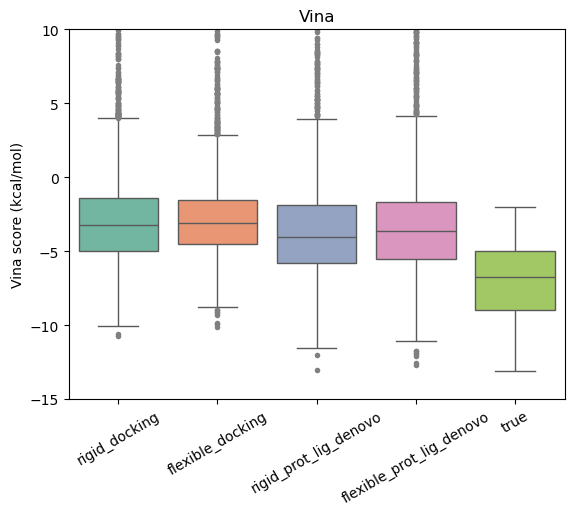

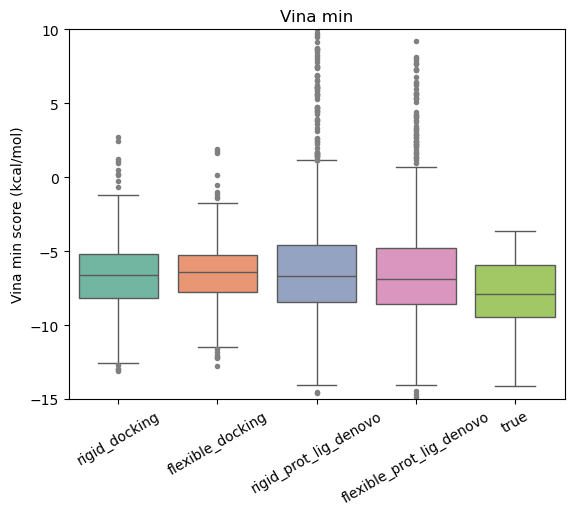

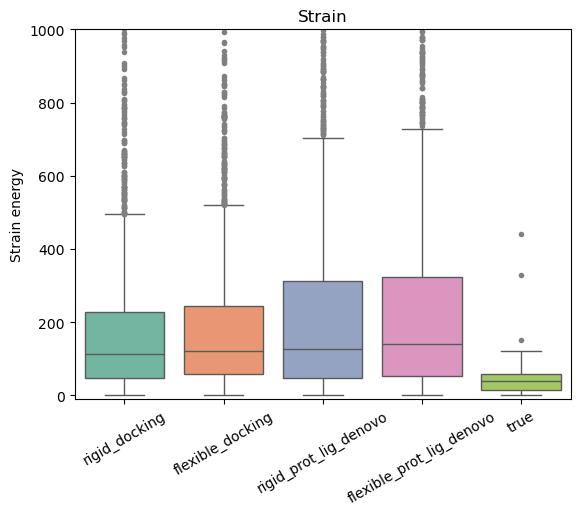

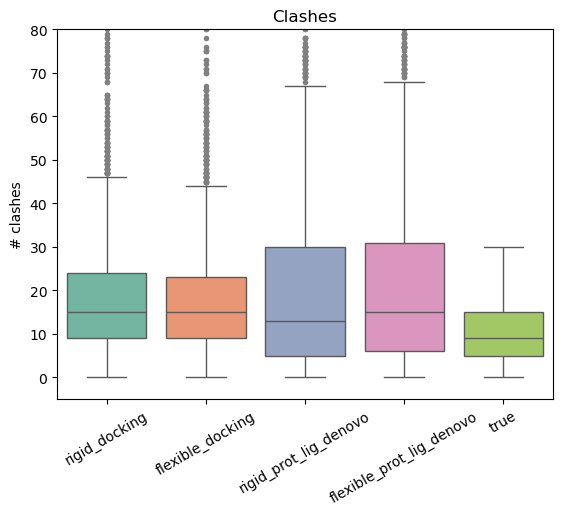

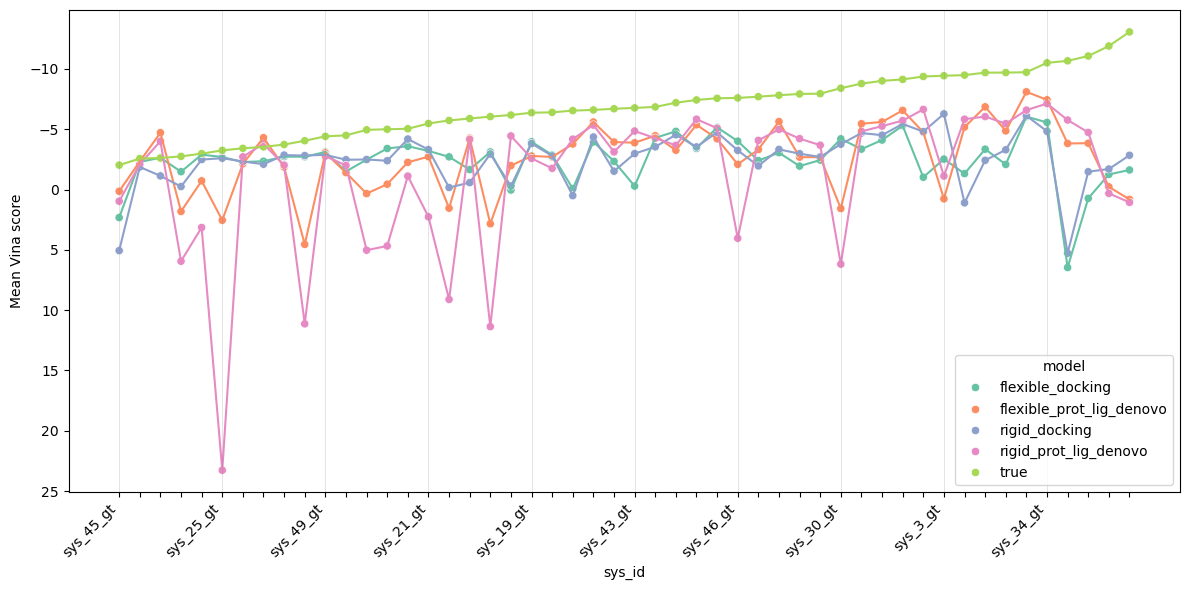

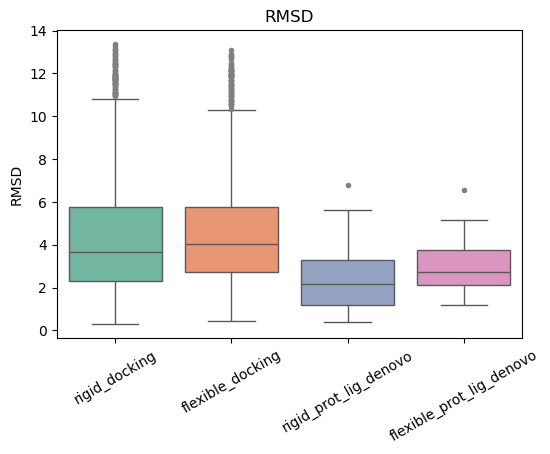

In [6]:
generate_plots(all_results)

In [7]:
# PoseBusters checks
pb_checks = [col for col in all_results if 'pb_' in col]
pb = all_results[all_results['model'] != 'true']
pb = pb[pb_checks].copy()
pb[['model','sys_id']] = all_results[['model', 'sys_id']]

pb_summary = pd.DataFrame(index=pb_checks, columns=all_results[all_results['model'] != 'true']['model'].unique())

for check in pb_checks:
    pb[check] = pd.to_numeric(pb[check], errors='coerce')
    sys_avg = pb.groupby(['model', 'sys_id'])[check].mean()
    model_avg = sys_avg.groupby('model').mean()

    pb_summary.loc[check, :] = model_avg

pb_summary

,rigid_docking,flexible_docking,rigid_prot_lig_denovo,flexible_prot_lig_denovo
pb_mol_pred_loaded,1.0,1.0,1.0,1.0
pb_mol_true_loaded,1.0,1.0,NaN,NaN
pb_mol_cond_loaded,1.0,1.0,1.0,1.0
pb_sanitization,1.0,1.0,1.0,1.0
pb_inchi_convertible,1.0,1.0,1.0,1.0
pb_all_atoms_connected,1.0,1.0,0.94896,0.952702
pb_molecular_formula,1.0,1.0,NaN,NaN
pb_molecular_bonds,1.0,1.0,NaN,NaN
pb_double_bond_stereochemistry,1.0,1.0,NaN,NaN
pb_tetrahedral_chirality,0.3864,0.44,NaN,NaN


In [9]:
# Table 2 from FLOWR
# 100 samples, 100 replicates

summary_table_1 = pd.DataFrame(index=all_results['model'].unique())
table_metrics = {'pb_pb_valid': 'PB-valid',
                 'strain': 'Strain',
                 'minimizedAffinity': 'Vina score',
                 'vina_min': 'Vina min score'}

for metric, name in table_metrics.items():
    # ensure numeric; non-numeric -> NaN
    all_results[metric] = pd.to_numeric(all_results[metric], errors='coerce')
    
    sys_avg = all_results.groupby(['model', 'sys_id'])[metric].mean()
    mean = sys_avg.groupby('model').mean()
    std = sys_avg.groupby('model').std()
    
    # safely handle NaNs in formatting
    summary_table_1[name] = mean.round(3).astype(str).fillna('NaN') + " ± " + std.round(3).astype(str).fillna('NaN')

summary_table_1

,PB-valid,Strain,Vina score,Vina min score
rigid_docking,0.06 ± 0.09,237.491 ± 277.004,-2.527 ± 2.233,-6.717 ± 1.735
flexible_docking,0.038 ± 0.076,226.716 ± 182.462,-2.48 ± 2.042,-6.507 ± 1.454
rigid_prot_lig_denovo,0.487 ± 0.264,1251.51 ± 3913.101,-1.268 ± 5.856,-5.853 ± 3.158
flexible_prot_lig_denovo,0.466 ± 0.242,315.894 ± 177.744,-2.687 ± 2.818,-6.459 ± 2.128
true,nan ± nan,53.713 ± 76.027,-6.829 ± 2.666,-7.92 ± 2.5


In [10]:
# Table 2 from DrugFlow

from scipy.stats import wasserstein_distance

models = list(set(all_results['model'].unique()) - {'true'})
summary_table_2 = pd.DataFrame(index=models)
table_metrics = {'minimizedAffinity': 'Vina score',
                 'CNNscore': 'Gnina score',
                 'HBAcceptor': 'H-bond (acc.)',
                 'HBDonor': 'H-bond (don.)',
                 'Hydrophobic': 'Hydrophobic'}

for metric, name in table_metrics.items():
    true_dist = all_results.loc[all_results['model'] == 'true', metric].dropna().astype(np.float64).to_numpy()

    for model in models:
        data_dist = all_results.loc[all_results['model'] == model, metric].dropna().astype(np.float64).to_numpy()
        summary_table_2.loc[model, name] = wasserstein_distance(data_dist, true_dist) 

summary_table_2

,Vina score,Gnina score,H-bond (acc.),H-bond (don.),Hydrophobic
flexible_docking,4.348614,0.528529,0.095519,0.052053,0.021951
rigid_prot_lig_denovo,5.471798,0.337089,0.079811,0.053494,0.025186
flexible_prot_lig_denovo,4.144173,0.406689,0.109755,0.060942,0.028969
rigid_docking,4.301634,0.465866,0.066541,0.046411,0.018357


# 1 Rigid Docking
• Condensed atom typing <br>
• No protein residue encoding

In [121]:
def compare_dist_w_true(type, data, metric, labels):

    data_melted = data.melt(value_vars=[metric, f"{metric}_true"], var_name="Type", value_name="Value")

    if type == 'violin':
        plt.figure(figsize=(6,4))
        sns.violinplot(data=data_melted, x="Type", y="Value", hue='Type', palette="Set2")

    elif type == 'all':
        plt.figure(figsize=(6,4))
    
        # Violin plot
        sns.violinplot(data=data_melted, x="Type", y="Value", hue="Type", inner=None, palette="Set2")
        
        flierprops = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgewidth=0)

        # Boxplot
        sns.boxplot(data=data_melted, x="Type", y="Value", hue="Type", flierprops=flierprops,
                    width=0.15, showcaps=True, boxprops={'facecolor':'none'}, 
                    showfliers=True, whiskerprops={'linewidth':2}, saturation=1, palette="Set2")
        
        # Raw points
        #sns.stripplot(data=data_melted, x="Type", y="Value", hue="Type", palette='dark:k', jitter=True, size=4, alpha=0.5)

    plt.title(labels['title'])
    plt.xlabel(None)
    plt.xticks(ticks=[0, 1], labels=['OMTRA', 'True'])
    plt.ylabel(labels['ylabel'])
    plt.show()
        

def generate_plots(data, plot_mean=False):
    violin_metrics = {'minimizedAffinity': {'title': 'Vina', 'ylabel': 'Vina score (kcal/mol)'},
                      'vina_min': {'title': 'Vina min', 'ylabel': 'Vina min score (kcal/mol)'},
                      'strain': {'title': 'Strain', 'ylabel': 'Strain energy'},
                      'clashes': {'title': 'Clashes', 'ylabel': '# clashes'}}
    
    if plot_mean:
        for metric, labels in violin_metrics.items():
            compare_dist_w_true(type='violin', data=data.groupby('sys_id')[[metric, f"{metric}_true"]].mean(), metric=metric, labels=labels)

    else:
        for metric, labels in violin_metrics.items():
            compare_dist_w_true(type='violin', data=data, metric=metric, labels=labels)


    # vina score system-level comparison
    grouped = data.groupby("sys_id")[["minimizedAffinity", "minimizedAffinity_true"]].mean().reset_index()

    # Sort by ascending vina score
    sorted_sys_ids = grouped.sort_values("minimizedAffinity_true", ascending=False)["sys_id"]

    melted = grouped.melt(id_vars="sys_id", 
                            value_vars=["minimizedAffinity", "minimizedAffinity_true"], 
                            var_name="Type", value_name="Affinity_avg")

    melted["sys_id"] = pd.Categorical(melted["sys_id"], categories=sorted_sys_ids, ordered=True)

    plt.figure(figsize=(11,7))
    sns.lineplot(
        data=melted,
        x="sys_id", y="Affinity_avg", hue='Type', palette='Set2', legend=False
    )
    sns.scatterplot(data=melted, x="sys_id", y="Affinity_avg", hue="Type", s=60, palette='Set2')


    plt.gca().invert_yaxis()

    ticks = plt.gca().get_xticks()
    labels = plt.gca().get_xticklabels()
    for i, label in enumerate(labels):
        if i % 10 != 0:
            label.set_visible(False)

    ax = plt.gca()
    for pos in range(0, len(sorted_sys_ids), 10):
        ax.axvline(x=pos, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
        
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Mean Vina score")
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(6,4))
    if plot_mean:
        data = data.groupby('sys_id')[['rmsd']].mean()
    df = pd.DataFrame({'rmsd': data['rmsd'], 'category': 'OMTRA'})
    sns.violinplot(data=df, x='category', y='rmsd', hue='category', palette='Set2')

    plt.title('RMSD')
    plt.xlabel('')
    plt.ylabel('rmsd')
    plt.show()


def pb_validity_summary(data):
    avg_pb_metrics = {}

    for col in data.columns:
        avg_pb_metrics[col] = data[col].mean()

    sorted_pb_metrics = sorted(avg_pb_metrics.items(), key=lambda item: item[1])

    # Print sorted key-value pairs
    for key, value in sorted_pb_metrics:
        print(f"{key}: {value}")

In [3]:
rd_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs/rigid_docking_condensed_metrics.csv')
rd_metrics

,sys_id,protein_id,gen_ligand_id,pb_mol_pred_loaded,pb_mol_true_loaded,pb_mol_cond_loaded,pb_sanitization,pb_inchi_convertible,pb_all_atoms_connected,pb_molecular_formula,...,Hydrophobic,clashes_true,strain_true,HBAcceptor_true,HBDonor_true,Hydrophobic_true,rmsd,system_id,ligand_id,ccd
0,sys_0_gt,protein_0,gen_ligands_0,True,True,True,True,True,True,True,...,0.000000,3.0,11.795014,0.000000,0.000000,0.000000,2.608409,4d47__2__1.B__1.K_1.L,1.L,GLC
1,sys_0_gt,protein_0,gen_ligands_1,True,True,True,True,True,True,True,...,0.000000,3.0,11.795014,0.000000,0.000000,0.000000,3.777991,4d47__2__1.B__1.K_1.L,1.L,GLC
2,sys_0_gt,protein_0,gen_ligands_2,True,True,True,True,True,True,True,...,0.000000,3.0,11.795014,0.000000,0.000000,0.000000,2.372172,4d47__2__1.B__1.K_1.L,1.L,GLC
3,sys_1_gt,protein_0,gen_ligands_0,True,True,True,True,True,True,True,...,0.400000,16.0,52.046641,0.500000,0.300000,0.200000,4.525068,2dg5__2__1.C_1.D__1.I,1.I,GLU
4,sys_1_gt,protein_0,gen_ligands_1,True,True,True,True,True,True,True,...,0.100000,16.0,52.046641,0.500000,0.300000,0.200000,1.389897,2dg5__2__1.C_1.D__1.I,1.I,GLU
5,sys_1_gt,protein_0,gen_ligands_2,True,True,True,True,True,True,True,...,0.300000,16.0,52.046641,0.500000,0.300000,0.200000,1.116076,2dg5__2__1.C_1.D__1.I,1.I,GLU
6,sys_2_gt,protein_0,gen_ligands_0,True,True,True,True,True,True,True,...,0.000000,13.0,27.095619,0.190476,0.095238,0.238095,5.896100,1knj__1__1.A_2.A__1.B_2.C_2.D,2.C,C5P
7,sys_2_gt,protein_0,gen_ligands_1,True,True,True,True,True,True,True,...,0.047619,13.0,27.095619,0.190476,0.095238,0.238095,6.022769,1knj__1__1.A_2.A__1.B_2.C_2.D,2.C,C5P
8,sys_2_gt,protein_0,gen_ligands_2,True,True,True,True,True,True,True,...,0.095238,13.0,27.095619,0.190476,0.095238,0.238095,4.228710,1knj__1__1.A_2.A__1.B_2.C_2.D,2.C,C5P
9,sys_3_gt,protein_0,gen_ligands_0,True,True,True,True,True,True,True,...,0.062500,0.0,151.138962,0.125000,0.000000,0.062500,1.126207,1knj__1__1.A_2.A__1.B_2.C_2.D,2.D,CDI


In [6]:
rd_metrics[[col for col in rd_metrics.columns if 'pb_' in col]]

,pb_mol_pred_loaded,pb_mol_true_loaded,pb_mol_cond_loaded,pb_sanitization,pb_inchi_convertible,pb_all_atoms_connected,pb_molecular_formula,pb_molecular_bonds,pb_double_bond_stereochemistry,pb_tetrahedral_chirality,...,pb_minimum_distance_to_protein,pb_minimum_distance_to_organic_cofactors,pb_minimum_distance_to_inorganic_cofactors,pb_minimum_distance_to_waters,pb_volume_overlap_with_protein,pb_volume_overlap_with_organic_cofactors,pb_volume_overlap_with_inorganic_cofactors,pb_volume_overlap_with_waters,pb_rmsd_≤_2å,pb_valid
0,True,True,True,True,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,False,False
1,True,True,True,True,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,False,False
2,True,True,True,True,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,False,False
3,True,True,True,True,True,True,True,True,True,True,...,False,True,True,True,False,True,True,True,False,False
4,True,True,True,True,True,True,True,True,True,True,...,False,True,True,True,False,True,True,True,True,False
5,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,False,True,True,True,True,False
6,True,True,True,True,True,True,True,True,True,False,...,False,True,True,True,True,True,True,True,False,False
7,True,True,True,True,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,False,False
8,True,True,True,True,True,True,True,True,True,True,...,False,True,True,True,True,True,True,True,False,False
9,True,True,True,True,True,True,True,True,True,False,...,False,True,True,True,True,True,True,True,True,False


In [13]:
len([col for col in rd_metrics.columns if 'pb_' in col])

28

## 1.1 PoseBusters Validity

In [122]:
pb_validity_summary(rd_metrics.iloc[:, 3:31])

pb_valid: 0.08
pb_tetrahedral_chirality: 0.36
pb_rmsd_≤_2å: 0.4
pb_minimum_distance_to_protein: 0.66
pb_volume_overlap_with_protein: 0.84
pb_internal_energy: 0.94
pb_mol_pred_loaded: 1.0
pb_mol_true_loaded: 1.0
pb_mol_cond_loaded: 1.0
pb_sanitization: 1.0
pb_inchi_convertible: 1.0
pb_all_atoms_connected: 1.0
pb_molecular_formula: 1.0
pb_molecular_bonds: 1.0
pb_double_bond_stereochemistry: 1.0
pb_bond_lengths: 1.0
pb_bond_angles: 1.0
pb_internal_steric_clash: 1.0
pb_aromatic_ring_flatness: 1.0
pb_non-aromatic_ring_non-flatness: 1.0
pb_double_bond_flatness: 1.0
pb_protein-ligand_maximum_distance: 1.0
pb_minimum_distance_to_organic_cofactors: 1.0
pb_minimum_distance_to_inorganic_cofactors: 1.0
pb_minimum_distance_to_waters: 1.0
pb_volume_overlap_with_organic_cofactors: 1.0
pb_volume_overlap_with_inorganic_cofactors: 1.0
pb_volume_overlap_with_waters: 1.0


## 1.2 Plots

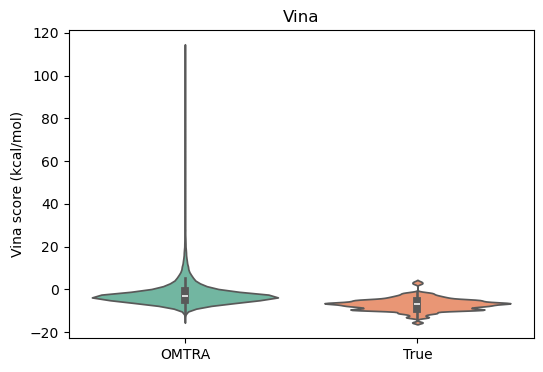

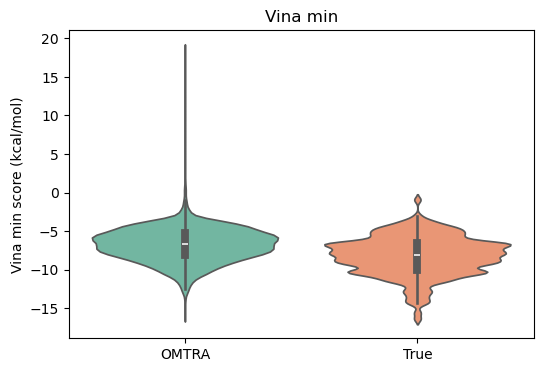

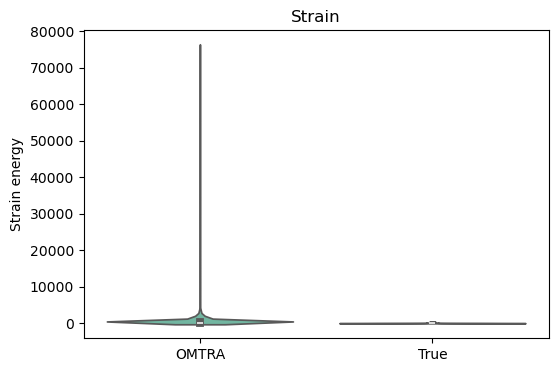

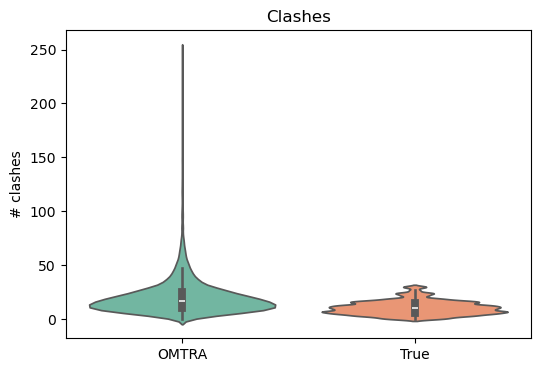

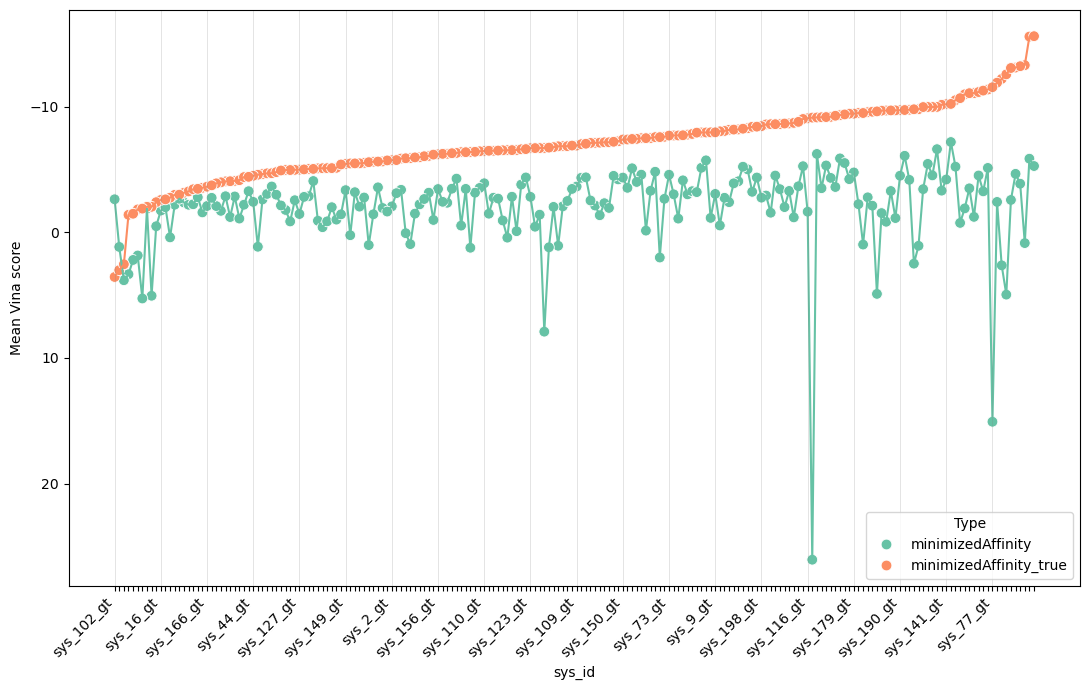

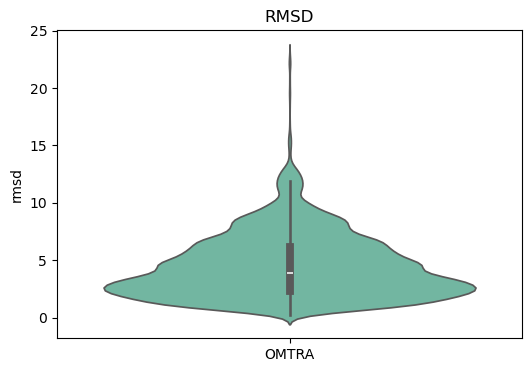

In [ ]:
generate_plots(rd_metrics)

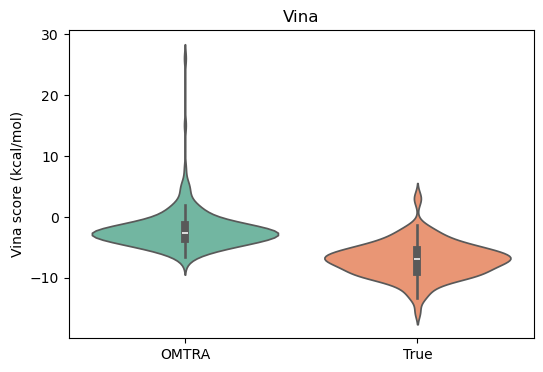

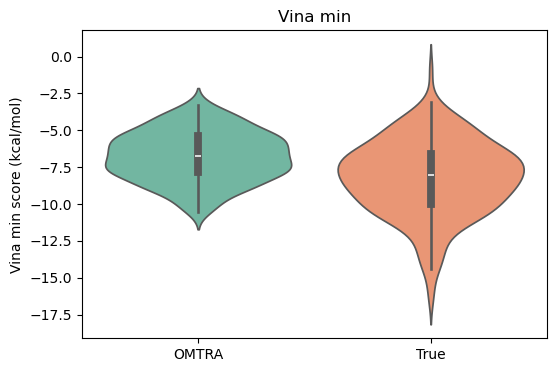

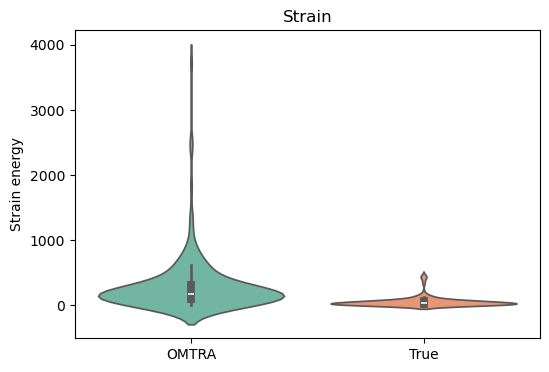

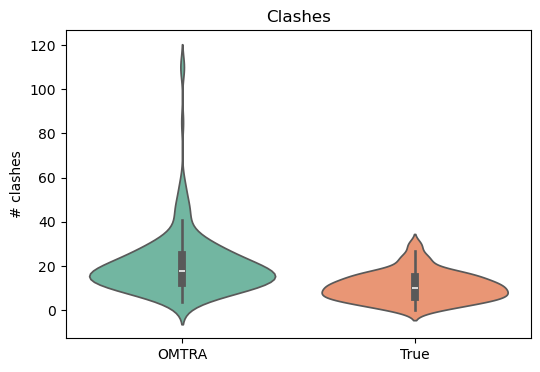

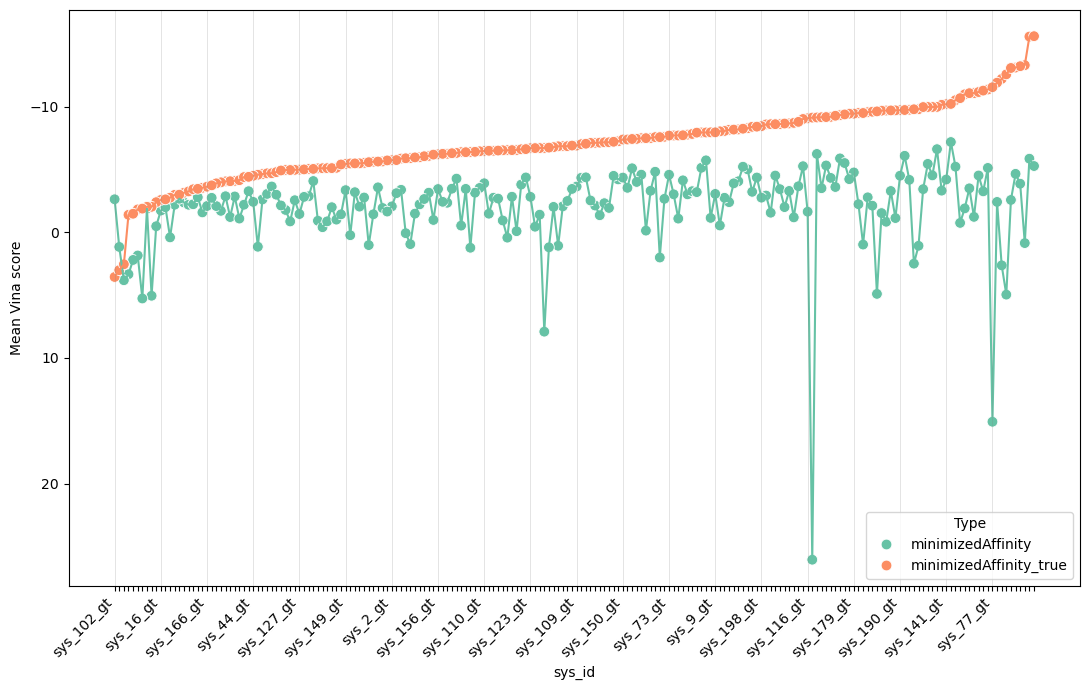

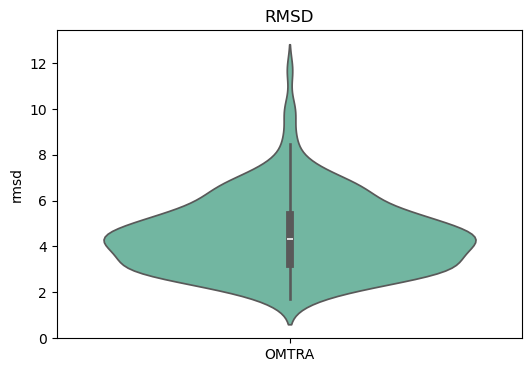

In [205]:
generate_plots(rd_metrics, plot_mean=True)

## 1.3 Summary Tables

In [ ]:
# Table 2 from FLOWR
# 100 samples, 100 replicates

summary_table_1 = pd.DataFrame(index=['OMTRA'])
table_metrics = {'pb_valid': 'PB-valid',
                 'strain': 'Strain',
                 'minimizedAffinity': 'Vina score',
                 'vina_min': 'Vina min score'}

for metric, name in table_metrics.items():
    mean = rd_metrics.iloc[0:10000,:].groupby('sys_id')[metric].mean().mean()
    std =  rd_metrics.iloc[0:10000,:].groupby('sys_id')[metric].mean().std()
    summary_table_1.loc['OMTRA', name] = mean.round(3).astype(str) + " ± " + std.round(3).astype(str)

summary_table_1

,PB-valid,Strain,Vina score,Vina min score
OMTRA,0.061 ± 0.082,278.725 ± 415.324,-2.301 ± 2.877,-6.752 ± 1.667


In [ ]:
# Table 2 from DrugFlow

from scipy.stats import wasserstein_distance

summary_table_2 = pd.DataFrame(index=['OMTRA'])
table_metrics = {'minimizedAffinity': 'Vina score',
                 'CNNscore': 'Gnina score',
                 'HBAcceptor': 'H-bond (acc.)',
                 'HBDonor': 'H-bond (don.)',
                 'Hydrophobic': 'Hydrophobic'}

for metric, name in table_metrics.items():
    summary_table_2.loc['OMTRA', name] = wasserstein_distance(rd_metrics[metric], rd_metrics.groupby('sys_id')[f'{metric}_true'].mean()) 

summary_table_2

,Vina score,Gnina score,H-bond (acc.),H-bond (don.),Hydrophobic
OMTRA,4.964148,0.459639,0.063581,0.038218,0.033835


# 2 Rigid Protein-Conditioned De Novo Design
• Condensed atom typing <br>
• No protein residue encoding

In [8]:
rdenovo_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs/fixed_protein_ligand_denovo_condensed_metrics.csv')
rdenovo_metrics

,sys_id,protein_id,gen_ligand_id,pb_mol_pred_loaded,pb_mol_true_loaded,pb_mol_cond_loaded,pb_sanitization,pb_inchi_convertible,pb_all_atoms_connected,pb_molecular_formula,...,Hydrophobic,clashes_true,strain_true,HBAcceptor_true,HBDonor_true,Hydrophobic_true,rmsd,system_id,ligand_id,ccd
0,sys_0_gt,protein_0,gen_ligands_0,True,True,True,True,True,True,False,...,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,NaN,4d47__2__1.B__1.K_1.L,1.L,GLC
1,sys_0_gt,protein_0,gen_ligands_1,True,True,True,True,True,True,False,...,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,NaN,4d47__2__1.B__1.K_1.L,1.L,GLC
2,sys_0_gt,protein_0,gen_ligands_2,True,True,True,True,True,True,False,...,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,NaN,4d47__2__1.B__1.K_1.L,1.L,GLC
3,sys_1_gt,protein_0,gen_ligands_0,True,True,True,True,True,True,False,...,0.228571,0.0,2.448447e-28,0.0,0.0,0.0,NaN,2dg5__2__1.C_1.D__1.I,1.I,GLU
4,sys_1_gt,protein_0,gen_ligands_1,True,True,True,True,True,True,False,...,0.270270,0.0,2.448447e-28,0.0,0.0,0.0,NaN,2dg5__2__1.C_1.D__1.I,1.I,GLU
5,sys_1_gt,protein_0,gen_ligands_2,True,True,True,True,True,True,False,...,0.080000,0.0,2.448447e-28,0.0,0.0,0.0,NaN,2dg5__2__1.C_1.D__1.I,1.I,GLU
6,sys_2_gt,protein_0,gen_ligands_0,True,True,True,True,True,True,False,...,0.230769,0.0,1.632298e-28,0.0,0.0,0.0,NaN,1knj__1__1.A_2.A__1.B_2.C_2.D,2.C,C5P
7,sys_2_gt,protein_0,gen_ligands_1,True,True,True,True,True,True,False,...,0.238095,0.0,1.632298e-28,0.0,0.0,0.0,NaN,1knj__1__1.A_2.A__1.B_2.C_2.D,2.C,C5P
8,sys_2_gt,protein_0,gen_ligands_2,True,True,True,True,True,True,False,...,0.192308,0.0,1.632298e-28,0.0,0.0,0.0,NaN,1knj__1__1.A_2.A__1.B_2.C_2.D,2.C,C5P
9,sys_3_gt,protein_0,gen_ligands_0,True,True,True,True,True,True,False,...,0.200000,0.0,-8.324720e-28,0.0,0.0,0.0,NaN,1knj__1__1.A_2.A__1.B_2.C_2.D,2.D,CDI


## 2.1 PoseBusters Validity

In [123]:
pb_validity_summary(rdenovo_metrics.iloc[:, 3:31])

TypeError: can only concatenate str (not "int") to str

## 2.2 Plots

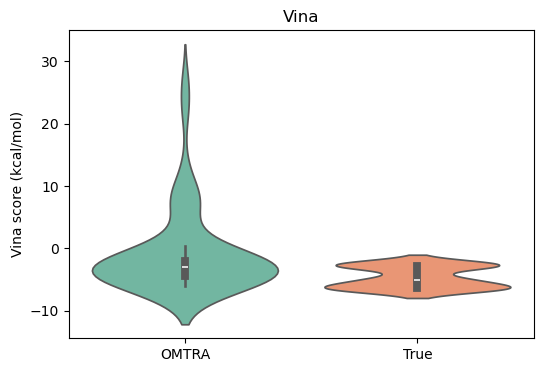

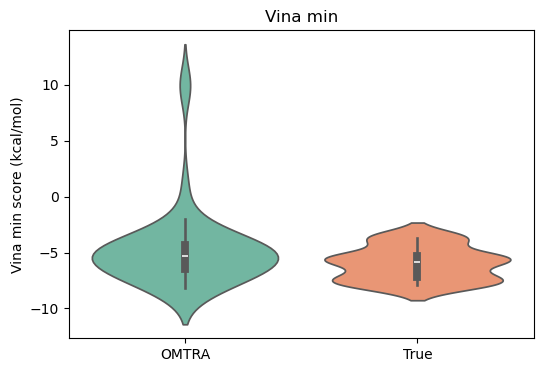

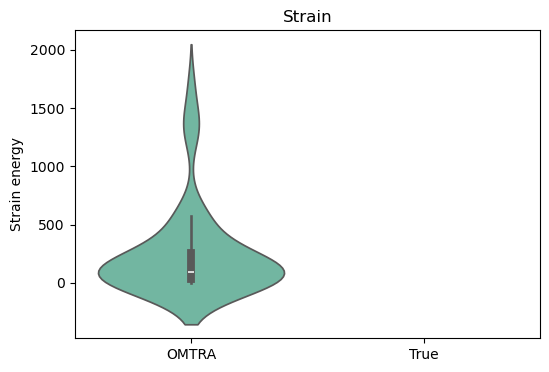

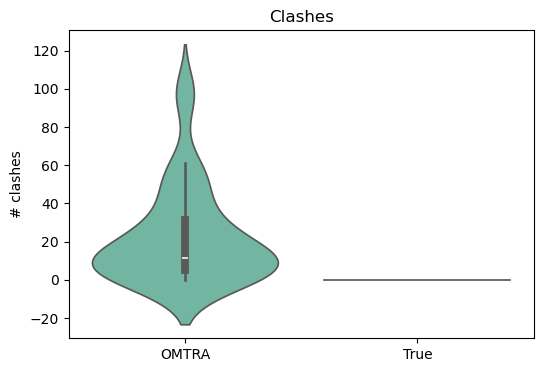

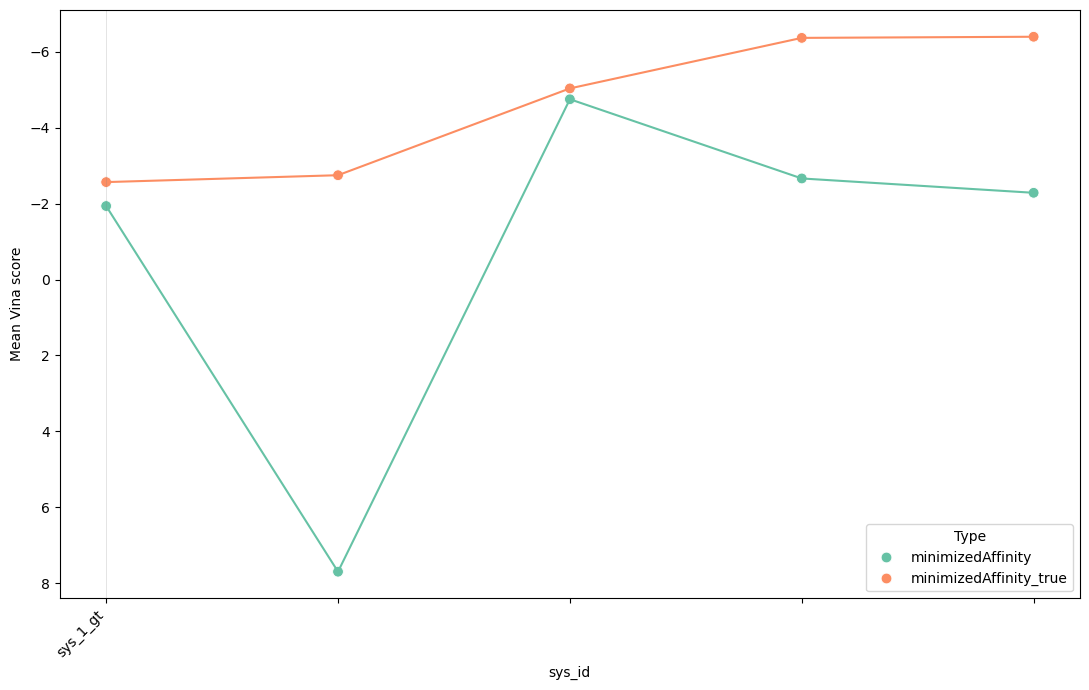

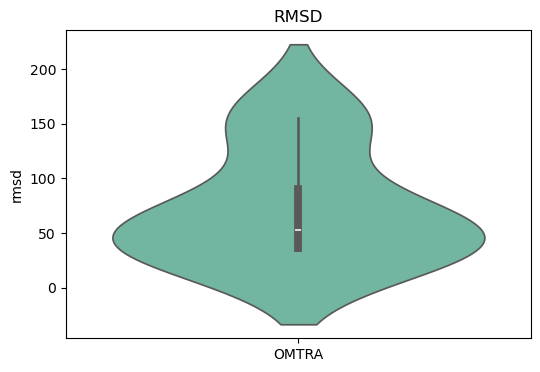

In [6]:
generate_plots(rdenovo_metrics)

## 2.3 Summary Tables

In [ ]:
# Table 2 from FLOWR
# 100 samples, 100 replicates

summary_table_1 = pd.DataFrame(index=['OMTRA'])
table_metrics = {'pb_valid': 'PB-valid',
                 'strain': 'Strain',
                 'minimizedAffinity': 'Vina score',
                 'vina_min': 'Vina min score'}

for metric, name in table_metrics.items():
    mean = rdenovo_metrics.iloc[0:10000,:].groupby('sys_id')[metric].mean().mean()
    std =  rdenovo_metrics.iloc[0:10000,:].groupby('sys_id')[metric].mean().std()
    summary_table_1.loc['OMTRA', name] = mean.round(3).astype(str) + " ± " + std.round(3).astype(str)

summary_table_1

In [ ]:
# Table 2 from DrugFlow

from scipy.stats import wasserstein_distance

summary_table_2 = pd.DataFrame(index=['OMTRA'])
table_metrics = {'minimizedAffinity': 'Vina score',
                 'CNNscore': 'Gnina score',
                 'HBAcceptor': 'H-bond (acc.)',
                 'HBDonor': 'H-bond (don.)',
                 'Hydrophobic': 'Hydrophobic'}

for metric, name in table_metrics.items():
    summary_table_2.loc['OMTRA', name] = wasserstein_distance(rdenovo_metrics[metric], rdenovo_metrics.groupby('sys_id')[f'{metric}_true'].mean()) 

summary_table_2

# 3 Flexible Docking
• Condensed atom typing <br>
• No protein residue encoding

In [20]:
fd_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs/flexible_docking_condensed_metrics.csv')
fd_metrics

,sys_id,protein_id,gen_ligand_id,pb_mol_pred_loaded,pb_mol_true_loaded,pb_mol_cond_loaded,pb_sanitization,pb_inchi_convertible,pb_all_atoms_connected,pb_molecular_formula,...,clashes_true,strain_true,HBAcceptor_true,HBDonor_true,PiStacking_true,Hydrophobic_true,rmsd,system_id,ligand_id,ccd
0,sys_0_gt,gen_prot_0,gen_ligands_0,True,True,True,True,True,True,True,...,7.0,16.299809,0.25,0.0,0.0,0.0,3.874784,NaN,NaN,NaN
1,sys_0_gt,gen_prot_1,gen_ligands_1,True,True,True,True,True,True,True,...,7.0,16.153991,0.25,0.0,0.0,0.0,3.332043,NaN,NaN,NaN
2,sys_0_gt,gen_prot_2,gen_ligands_2,True,True,True,True,True,True,True,...,7.0,16.253748,0.25,0.0,0.0,0.0,3.069607,NaN,NaN,NaN
3,sys_1_gt,gen_prot_0,gen_ligands_0,True,True,True,True,True,True,True,...,3.0,11.150000,0.00,0.0,0.0,0.0,3.139641,NaN,NaN,NaN
4,sys_1_gt,gen_prot_1,gen_ligands_1,True,True,True,True,True,True,True,...,3.0,11.787120,0.00,0.0,0.0,0.0,2.440915,NaN,NaN,NaN
5,sys_1_gt,gen_prot_2,gen_ligands_2,True,True,True,True,True,True,True,...,3.0,11.492172,0.00,0.0,0.0,0.0,2.737873,NaN,NaN,NaN


## 3.1 PoseBusters Validity

In [124]:
pb_validity_summary(fd_metrics.iloc[:, 3:31])

pb_valid: 0.12
pb_rmsd_≤_2å: 0.28
pb_tetrahedral_chirality: 0.4
pb_minimum_distance_to_protein: 0.64
pb_volume_overlap_with_protein: 0.92
pb_internal_energy: 0.96
pb_bond_lengths: 0.98
pb_bond_angles: 0.98
pb_mol_pred_loaded: 1.0
pb_mol_true_loaded: 1.0
pb_mol_cond_loaded: 1.0
pb_sanitization: 1.0
pb_inchi_convertible: 1.0
pb_all_atoms_connected: 1.0
pb_molecular_formula: 1.0
pb_molecular_bonds: 1.0
pb_double_bond_stereochemistry: 1.0
pb_internal_steric_clash: 1.0
pb_aromatic_ring_flatness: 1.0
pb_non-aromatic_ring_non-flatness: 1.0
pb_double_bond_flatness: 1.0
pb_protein-ligand_maximum_distance: 1.0
pb_minimum_distance_to_organic_cofactors: 1.0
pb_minimum_distance_to_inorganic_cofactors: 1.0
pb_minimum_distance_to_waters: 1.0
pb_volume_overlap_with_organic_cofactors: 1.0
pb_volume_overlap_with_inorganic_cofactors: 1.0
pb_volume_overlap_with_waters: 1.0


## 3.2 Plots

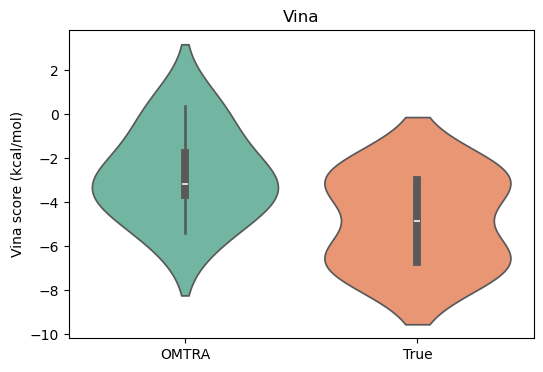

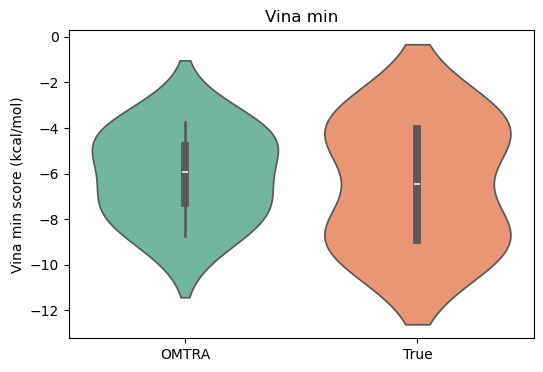

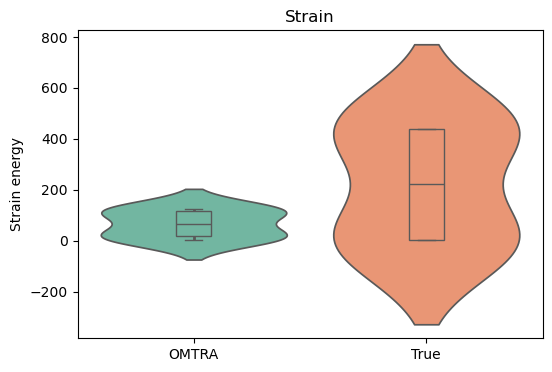

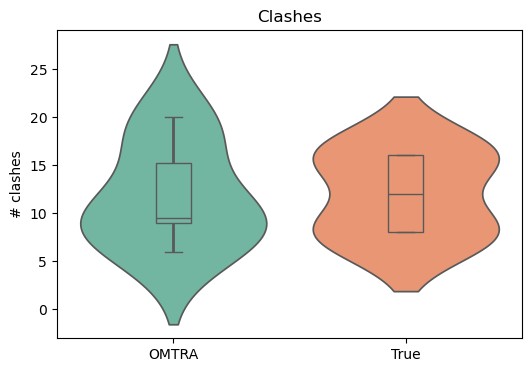

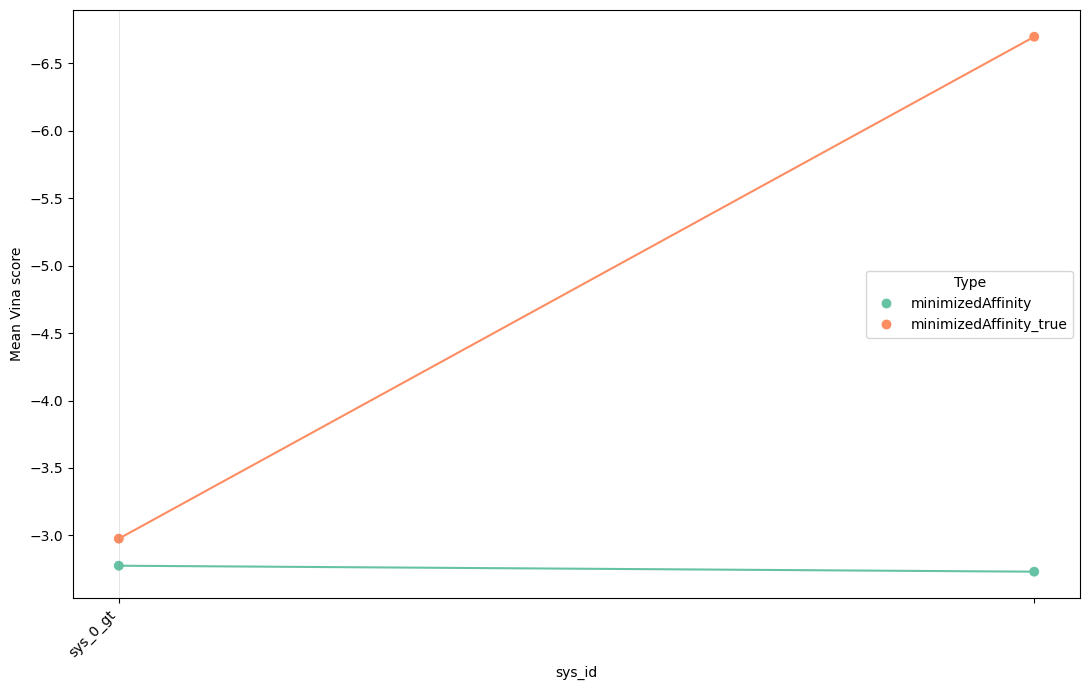

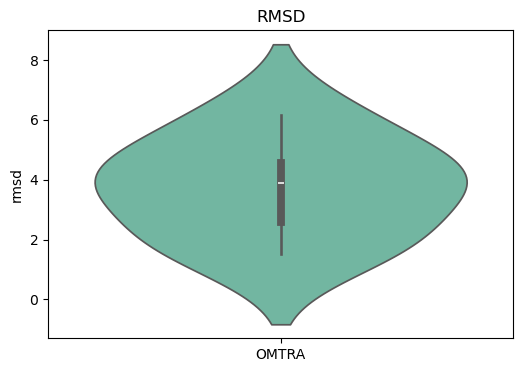

In [193]:
generate_plots(fd_metrics)

## 3.3 Summary Tables

In [189]:
summary_table_1 = pd.DataFrame(index=['OMTRA'])
table_metrics = {'pb_valid': 'PB-valid',
                 'strain': 'Strain',
                 'minimizedAffinity': 'Vina score',
                 'vina_min': 'Vina min score'}

for metric, name in table_metrics.items():
    mean = fd_metrics.groupby('sys_id')[metric].mean().mean()
    std =  fd_metrics.groupby('sys_id')[metric].mean().std()
    summary_table_1.loc['OMTRA', name] = mean.round(3).astype(str) + " ± " + std.round(3).astype(str)

summary_table_1

,PB-valid,Strain,Vina score,Vina min score
OMTRA,0.167 ± 0.236,65.906 ± 70.75,-2.753 ± 0.031,-6.07 ± 2.324


In [190]:
# Table 2 from DrugFlow
from scipy.stats import wasserstein_distance

summary_table_2 = pd.DataFrame(index=['OMTRA'])
table_metrics = {'minimizedAffinity': 'Vina score',
                 'CNNscore': 'Gnina score',
                 'HBAcceptor': 'H-bond (acc.)',
                 'HBDonor': 'H-bond (don.)',
                 'Hydrophobic': 'Hydrophobic'}

for metric, name in table_metrics.items():
    summary_table_2.loc['OMTRA', name] = wasserstein_distance(fd_metrics[metric], fd_metrics.groupby('sys_id')[f'{metric}_true'].mean()) 

summary_table_2

,Vina score,Gnina score,H-bond (acc.),H-bond (don.),Hydrophobic
OMTRA,2.138985,0.425216,0.13859,0.090203,0.005376


# 4 Flexible Protein-Conditioned De Novo Design
• Condensed atom typing <br>
• No protein residue encoding

In [19]:
fdenovo_metrics = pd.read_csv('/net/galaxy/home/koes/ltoft/OMTRA/omtra_pipelines/docking_eval/outputs/protein_ligand_denovo_condensed_metrics.csv')
fdenovo_metrics

,sys_id,protein_id,gen_ligand_id,pb_mol_pred_loaded,pb_mol_true_loaded,pb_mol_cond_loaded,pb_sanitization,pb_inchi_convertible,pb_all_atoms_connected,pb_molecular_formula,...,clashes_true,strain_true,HBAcceptor_true,HBDonor_true,PiStacking_true,Hydrophobic_true,rmsd,system_id,ligand_id,ccd
0,sys_0_gt,gen_prot_0,gen_ligands_0,True,True,True,True,True,True,True,...,0.0,NaN,0.0,0.0,0.0,0.0,151.752631,NaN,NaN,NaN
1,sys_0_gt,gen_prot_1,gen_ligands_1,True,True,True,True,True,True,False,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,sys_0_gt,gen_prot_2,gen_ligands_2,True,True,True,True,True,True,False,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,sys_1_gt,gen_prot_0,gen_ligands_0,True,True,True,True,True,True,True,...,0.0,NaN,0.0,0.0,0.0,0.0,154.831594,NaN,NaN,NaN
4,sys_1_gt,gen_prot_1,gen_ligands_1,True,True,True,True,True,True,False,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5,sys_1_gt,gen_prot_2,gen_ligands_2,True,True,True,True,True,True,False,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


## 4.1 PoseBusters Validity

In [126]:
pb_validity_summary(fdenovo_metrics.iloc[:,3:31])

pb_tetrahedral_chirality: 0.0
pb_valid: 0.0
pb_molecular_formula: 0.02
pb_molecular_bonds: 0.02
pb_rmsd_≤_2å: 0.02
pb_minimum_distance_to_protein: 0.5
pb_volume_overlap_with_protein: 0.82
pb_internal_energy: 0.92
pb_all_atoms_connected: 0.94
pb_bond_lengths: 0.94
pb_bond_angles: 0.98
pb_aromatic_ring_flatness: 0.98
pb_mol_pred_loaded: 1.0
pb_mol_true_loaded: 1.0
pb_mol_cond_loaded: 1.0
pb_sanitization: 1.0
pb_inchi_convertible: 1.0
pb_double_bond_stereochemistry: 1.0
pb_internal_steric_clash: 1.0
pb_non-aromatic_ring_non-flatness: 1.0
pb_double_bond_flatness: 1.0
pb_protein-ligand_maximum_distance: 1.0
pb_minimum_distance_to_organic_cofactors: 1.0
pb_minimum_distance_to_inorganic_cofactors: 1.0
pb_minimum_distance_to_waters: 1.0
pb_volume_overlap_with_organic_cofactors: 1.0
pb_volume_overlap_with_inorganic_cofactors: 1.0
pb_volume_overlap_with_waters: 1.0


## 4.2 Plots

In [ ]:
generate_plots(fdenovo_metrics)

## 4.3 Summary Tables

In [ ]:
# Table 2 from FLOWR
# 100 samples, 100 replicates

summary_table_1 = pd.DataFrame(index=['OMTRA'])
table_metrics = {'pb_valid': 'PB-valid',
                 'strain': 'Strain',
                 'minimizedAffinity': 'Vina score',
                 'vina_min': 'Vina min score'}

for metric, name in table_metrics.items():
    mean = fdenovo_metrics.iloc[0:10000,:].groupby('sys_id')[metric].mean().mean()
    std =  fdenovo_metrics.iloc[0:10000,:].groupby('sys_id')[metric].mean().std()
    summary_table_1.loc['OMTRA', name] = mean.round(3).astype(str) + " ± " + std.round(3).astype(str)

summary_table_1

In [ ]:
# Table 2 from DrugFlow

from scipy.stats import wasserstein_distance

summary_table_2 = pd.DataFrame(index=['OMTRA'])
table_metrics = {'minimizedAffinity': 'Vina score',
                 'CNNscore': 'Gnina score',
                 'HBAcceptor': 'H-bond (acc.)',
                 'HBDonor': 'H-bond (don.)',
                 'Hydrophobic': 'Hydrophobic'}

for metric, name in table_metrics.items():
    summary_table_2.loc['OMTRA', name] = wasserstein_distance(fdenovo_metrics[metric], fdenovo_metrics.groupby('sys_id')[f'{metric}_true'].mean()) 

summary_table_2